In [1]:
# !pip install datasets
# !pip install accelerate -U

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import random
import numpy as np
import torch
from torch import nn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from datasets import Dataset, concatenate_datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, AutoTokenizer, AutoConfig, TrainingArguments, Trainer, BertConfig, BertModel, BertPreTrainedModel, RobertaConfig, RobertaModel

c:\Users\marco\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# print(f"Current work directory: {Path.cwd()}")    
dataset_folder = Path.cwd().joinpath("hvd_data")    # for local use
# dataset_folder = Path.cwd().joinpath("/content/drive/MyDrive/NLP_assignments/assignment2/hvd_data") # for Colab use

In [5]:
# RANDOM_SEED = 44
# np.random.seed(RANDOM_SEED)
# transformers.set_seed(RANDOM_SEED)
torch.cuda.is_available()

True

In [6]:
arg_test = dataset_folder.joinpath('arguments-test.tsv')
arg_val = dataset_folder.joinpath('arguments-validation.tsv')
arg_train = dataset_folder.joinpath('arguments-training.tsv')

label_test = dataset_folder.joinpath('labels-test.tsv')
label_val = dataset_folder.joinpath('labels-validation.tsv')
label_train = dataset_folder.joinpath('labels-training.tsv')

In [7]:
# Loading original datasets
df_arg_test = pd.read_csv(arg_test, sep='\t', header=0)
df_arg_val = pd.read_csv(arg_val, sep='\t', header=0)
df_arg_train = pd.read_csv(arg_train, sep='\t', header=0)

df_label_test = pd.read_csv(label_test, sep='\t', header=0)
df_label_val = pd.read_csv(label_val, sep='\t', header=0)
df_label_train = pd.read_csv(label_train, sep='\t', header=0)

Level 2 categories to obtain by merge:
* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

Data splits
* **Train**: 5393 arguments
* **Validation**: 1896 arguments
* **Test**: 1576 arguments

In [8]:
# Merging datasets based on Argument ID
df_train = df_arg_train.merge(df_label_train, left_on='Argument ID', right_on='Argument ID')
df_val = df_arg_val.merge(df_label_val, left_on='Argument ID', right_on='Argument ID')
df_test = df_arg_test.merge(df_label_test, left_on='Argument ID', right_on='Argument ID')

In [9]:
# Obtaining level 2 columns by OR-concatenating existing ones
level_2 = {'Openness to change': ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism'],
           'Self-enhancement': ['Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face'],
           'Conservation': ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility'],
           'Self-transcendence': ['Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']
           }

def merge_columns(row, columns_to_merge):
    return any(row[columns_to_merge])

# Create columns by merging
for df in [df_train, df_val, df_test]:
    for l in level_2.keys():
        df[l] = df.apply(merge_columns, columns_to_merge=level_2[l], axis=1)
        df[l] = df[l].astype(int)

In [10]:
# Dropping previous columns (first one is Argument ID)
train_split = df_train.drop(columns=df_label_train.columns[1:])
val_split = df_val.drop(columns=df_label_val.columns[1:])
test_split = df_test.drop(columns=df_label_test.columns[1:])

# Convert 'Stance' column to 0-1
for split in [train_split, val_split, test_split]:
    split['Stance'] = split['Stance'].map({'in favor of': 1, 'against': 0})

In [11]:
print("Training set shape:", len(train_split))
print("Validation set shape:", len(val_split))
print("Test set shape:", len(test_split))

Training set shape: 5393
Validation set shape: 1896
Test set shape: 1576


In [12]:
train_split

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,0,0,1,1
...,...,...,...,...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,1,"On the one hand, we have Russia killing countl...",0,1,1,1
5389,E08017,Food whose production has been subsidized with...,1,The subsidies were originally intended to ensu...,0,0,1,1
5390,E08018,Food whose production has been subsidized with...,1,These products come mainly from large enterpri...,0,0,0,1
5391,E08019,Food whose production has been subsidized with...,1,Subsidies often make farmers in recipient coun...,0,0,1,1


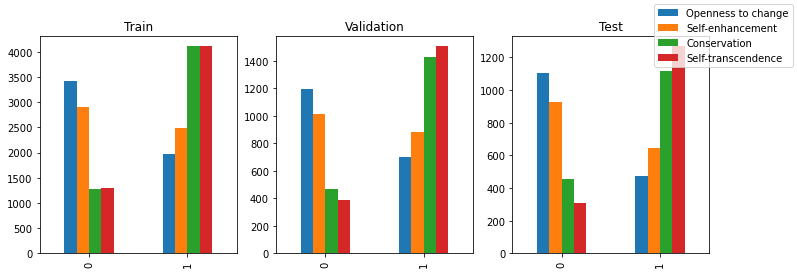

In [13]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
train_split.iloc[:, 4:].apply(pd.value_counts).plot(kind='bar', title='Train', ax = axs[0], legend = False)
val_split.iloc[:, 4:].apply(pd.value_counts).plot(kind='bar', title='Validation', ax = axs[1], legend = False)
test_split.iloc[:, 4:].apply(pd.value_counts).plot(kind='bar', title='Test', ax = axs[2], legend = False)
fig.legend(labels=list(level_2.keys()), loc='upper right')

<AxesSubplot:>

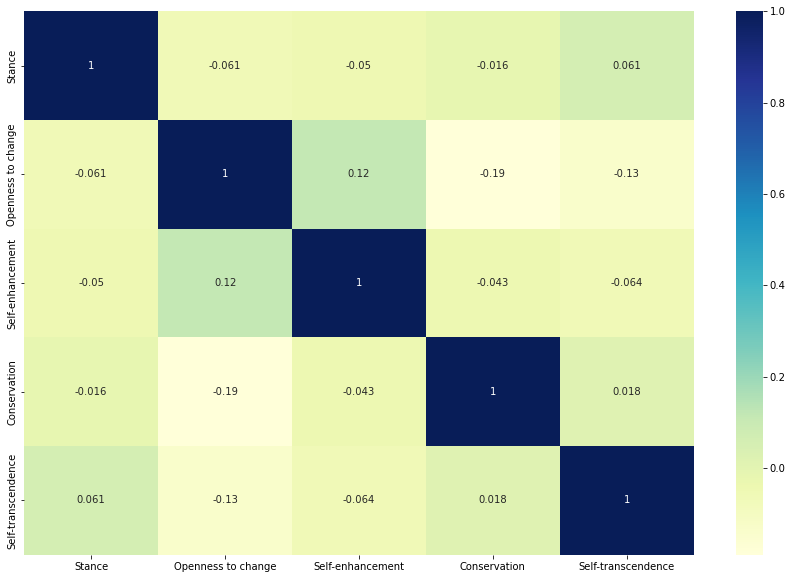

In [14]:
corr = train_split[train_split.columns].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="YlGnBu", annot=True)
# Conservation <-!-> Openness to change
# Self-transcendence <-!-> Openness to change
# Stance <---> Self-transcendence
# Conservation <---> Self-transcendence
# Openness to change <---> Self-enhancement

In [15]:
# Add labels column
for split in [train_split, val_split, test_split]:
    split["labels"] = split[split.columns[4:8]].apply(lambda row: row.astype(float).tolist(), axis=1)

In [16]:
#sanity check
for split in [train_split, val_split, test_split]:
  res = split.apply(lambda row: all([row[4] == row[8][0], row[5] == row[8][1],row[6] == row[8][2], row[7] == row[8][3]]), axis = 1 ).all()
  print("Sanity check ", res)

Sanity check  True
Sanity check  True
Sanity check  True


In [17]:
train_split

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence,labels
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,0,1,1,0,"[0.0, 1.0, 1.0, 0.0]"
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,0,0,1,1,"[0.0, 0.0, 1.0, 1.0]"
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,0,0,1,1,"[0.0, 0.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,1,"On the one hand, we have Russia killing countl...",0,1,1,1,"[0.0, 1.0, 1.0, 1.0]"
5389,E08017,Food whose production has been subsidized with...,1,The subsidies were originally intended to ensu...,0,0,1,1,"[0.0, 0.0, 1.0, 1.0]"
5390,E08018,Food whose production has been subsidized with...,1,These products come mainly from large enterpri...,0,0,0,1,"[0.0, 0.0, 0.0, 1.0]"
5391,E08019,Food whose production has been subsidized with...,1,Subsidies often make farmers in recipient coun...,0,0,1,1,"[0.0, 0.0, 1.0, 1.0]"


In [18]:
train_data = Dataset.from_pandas(train_split)
val_data = Dataset.from_pandas(val_split)
test_data = Dataset.from_pandas(test_split)

In [19]:
train_data[0]

{'Argument ID': 'A01002',
 'Conclusion': 'We should ban human cloning',
 'Stance': 1,
 'Premise': 'we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.',
 'Openness to change': 0,
 'Self-enhancement': 0,
 'Conservation': 1,
 'Self-transcendence': 0,
 'labels': [0.0, 0.0, 1.0, 0.0],
 '__index_level_0__': 0}

In [21]:
# Metrics (copied from original paper)
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    return ((y_pred > thresh) == y_true.bool()).float().mean().item()


def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 4)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 4)

    return f1_scores


def compute_metrics(eval_pred, value_classes):
    predictions, labels = eval_pred
    f1scores = f1_score_per_label(predictions, labels, value_classes)
    return {'accuracy': round(accuracy_thresh(predictions, labels), 4), 'f1-score': f1scores,
            'macro-avg-f1score': f1scores['avg-f1-score']}

In [22]:
def print_loss(trainer_history):
  train_loss = []
  val_loss = []
  i = -1
  hist = trainer_history[:-1]
  # Extract val and train loss from the trainer
  for el in hist:
    if i == -1:
      train_loss.append({'loss': el["loss"], "epoch": el["epoch"]})
    else:
      val_loss.append({'loss': el["eval_loss"], "epoch": el["epoch"]})
    i*=-1

  # Data to plot
  train_x = [el["epoch"] for el in train_loss]
  train_y = [el["loss"] for el in train_loss]

  val_x = [el["epoch"] for el in val_loss]
  val_y = [el["loss"] for el in val_loss]

  _, ax = plt.subplots()
  ax.set_xlabel('N. Epoch')
  ax.set_ylabel('Loss')

  ax.plot(train_x, train_y, linewidth=3.0, label="Train")
  ax.plot(val_x, val_y, linestyle='--', linewidth=3.0, label="Validation")
  ax.legend()

  plt.show()

In [23]:
label_columns = train_split.columns[4:8]

label2id = {label:i for i, label in enumerate(label_columns)}
id2label = {i:label for i, label in enumerate(label_columns)}

In [24]:
def preprocess_text(texts, type):
    if type == "CP":
        encoding = tokenizer(texts['Premise'], texts['Conclusion'], truncation=True)
    elif type == "C":
        encoding = tokenizer(texts['Conclusion'], truncation=True)
    elif type == "P":
        encoding = tokenizer(texts['Premise'], truncation=True)
    elif type == "CPS":
        encoding = tokenizer(texts['Premise'], texts['Conclusion'], truncation=True)
        encoding["stance"] = texts["Stance"]
    return encoding


In [25]:
def get_datasets(train, val, test, type, cols_to_remove):
    if type not in ['C', 'P', 'CP', 'CPS']:
        raise ValueError(f"type must be in {['C', 'P', 'CP', 'CPS']}, but {type} was given")

    train_data = train.map(lambda text: preprocess_text(text, type), batched=True, remove_columns=cols_to_remove)
    val_data = val.map(lambda text: preprocess_text(text, type), batched=True, remove_columns=cols_to_remove)
    test_data = test.map(lambda text: preprocess_text(text, type), batched=True, remove_columns=cols_to_remove)

    train_data.set_format("torch")
    val_data.set_format("torch")
    test_data.set_format("torch")

    return train_data, val_data, test_data


In [26]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        for label in labels:
            c = np.array(data[label])
            w = len(c[c==0])/len(c[c==1])   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [27]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss


def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=16, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="steps",
        lr_scheduler_type="cosine_with_restarts",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='macro-avg-f1score',
        report_to='none'
    )

    pos_weight = init_pos_weight(concatenate_datasets([train_data, val_data, test_data]), label2id.keys(), class_weights)

    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred, list(level_2.keys())),
    )

    return trainer

In [28]:
cols = train_data.column_names
cols.remove('labels')

In [29]:
# model_card = 'bert-base-uncased'
# model_card = 'microsoft/deberta-v3-base'
model_card = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Models

In [30]:
class Baseline:
    def __init__(self, strategy, data, labels):
        self.strategy = strategy
        self.classifier = DummyClassifier(strategy=strategy)
        self.X = data
        self.Y = labels

    def score(self):
        out_dict = {'accuracy': None, 'f1-score': {}, 'macro-avg-f1score': None}
        avg_accuracy = []
        for column in self.Y.columns:
            self.classifier.fit(self.X, self.Y[column])
            self.classifier.predict(self.X)
            avg_accuracy.append(self.classifier.score(self.X, self.Y[column]))
            out_dict["f1-score"][column] = round(f1_score(self.Y[column], self.classifier.predict(self.X), zero_division=0), 4)

        out_dict['accuracy'] = round(sum(avg_accuracy)/len(avg_accuracy), 4)
        out_dict['f1-score']['avg-f1-score'] = out_dict["macro-avg-f1score"] = round(sum(out_dict["f1-score"].values())/len(out_dict["f1-score"]), 4)
        return out_dict

In [147]:
class BERT_CPS(BertPreTrainedModel):
    def __init__(self, card, id2label, label2id, load=None, pos_weight=None, dropout_prob=0.3):
        self.card = card.split("-")[0]

        if self.card == "roberta":
            self.config = RobertaConfig.from_pretrained(model_card, output_attentions=True, output_hidden_states=True)
        elif self.card == "bert":
            self.config = BertConfig.from_pretrained(model_card, output_attentions=True, output_hidden_states=True)
        self.config.num_labels = 4
        self.config.id2label = id2label
        self.config.label2id = label2id
        self.config.hidden_dropout_prob = dropout_prob

        super().__init__(self.config)
        self.core = self.initialize_model(load)

        if pos_weight == None:
            self.pos_weight = torch.ones([self.config.num_labels]).to("cuda")
        else:
            self.pos_weight = pos_weight

        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size+1, self.config.num_labels)
        self.post_init()

    def initialize_model(self, load):
        if load == None:
            if self.card == "roberta":
                return RobertaModel(self.config)
            elif self.card == "bert":
                return BertModel(self.config)
        else:
            if self.card == "roberta":
                return RobertaModel.from_pretrained(load, local_files_only=True)
            elif self.card == "bert":
                return BertModel.from_pretrained(load, local_files_only=True)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        return_dict=None,
        stance = None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.core(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
        )

        # Concat with stance ---> (8)
        pooled_output = outputs[1]  # (batch_size, hidden_dim) ---> (8, 768)
        concat_stance = torch.cat((pooled_output, stance.unsqueeze(1)), dim=1)

        dropped_output = self.dropout(concat_stance)
        logits = self.classifier(dropped_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [32]:
# Create datasets
train_data_C, val_data_C, test_data_C = get_datasets(train_data, val_data, test_data, "C", cols)
train_data_CP, val_data_CP, test_data_CP = get_datasets(train_data, val_data, test_data, "CP", cols)
train_data_CPS, val_data_CPS, test_data_CPS = get_datasets(train_data, val_data, test_data, "CPS", cols)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [33]:
def define_models(model_card):
    config = AutoConfig.from_pretrained(model_card)
    config.hidden_dropout_prob = 0.3
    config.problem_type = "multi_label_classification"
    config.num_labels = 4
    config.id2label = id2label
    config.label2id = label2id

    # model_C = AutoModelForSequenceClassification.from_pretrained(model_card, problem_type="multi_label_classification", num_labels=4, id2label=id2label, label2id=label2id)
    model_C = AutoModelForSequenceClassification.from_config(config)
    model_C.train() #set back to training mode
    # model_CP = AutoModelForSequenceClassification.from_pretrained(model_card, problem_type="multi_label_classification", num_labels=4, id2label=id2label, label2id=label2id)
    model_CP = AutoModelForSequenceClassification.from_config(config)
    model_CP.train() #set back to training mode

    pos_weight = init_pos_weight(concatenate_datasets([train_data, val_data, test_data]), label2id.keys(), True)
    model_CPS = BERT_CPS(model_card, id2label, label2id, pos_weight=pos_weight, dropout_prob = config.hidden_dropout_prob)

    return model_C, model_CP, model_CPS

In [34]:
def test_all(trainers, test, model_names):
    """trainers and test must have the same length

    Args:
        trainers (list): list containing the trainers
        test (list): list containing the test datasets
        model_names (list): list containing the models' names
    """

    test_metrics = []
    for trainer, dataset, name in zip(trainers, test, model_names):
        test_prediction_info = trainer.predict(dataset)
        test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))
        # print(f"{name} on test set")
        # print(test_metrics)
    return test_metrics

In [170]:
def build_confusion_matrix(trainer, test_data, norm=True):
  prediction_out = trainer.predict(test_data)
  y_pred = prediction_out.predictions
  y_pred = torch.from_numpy(y_pred)
  y_pred = y_pred.sigmoid()
  y_pred = (y_pred > 0.5).numpy()
  y_true = test_data["labels"].bool().numpy()
  if norm:
    return [matrix/matrix.sum() for matrix in multilabel_confusion_matrix(y_true, y_pred)]
  else:
    return multilabel_confusion_matrix(y_true, y_pred)

In [36]:
def get_wrongly_classified(trainer, test_data):
    prediction_out = trainer.predict(test_data)
    y_pred = prediction_out.predictions
    y_pred = torch.from_numpy(y_pred)
    y_pred = y_pred.sigmoid()
    y_pred = (y_pred > 0.5).numpy()
    y_true = torch.from_numpy(prediction_out.label_ids).bool().numpy()
    res = np.where(y_pred != y_true)

    key_list = list(level_2.keys())
    out_samples = []
    for i,j in zip(res[0], res[1]):
        decoded = tokenizer.decode(test_data[int(i)]["input_ids"])
        correct_label = dict(zip(key_list, y_true[0]))
        pred_label = dict(zip(key_list, y_pred[0]))

        sample = {
            "decoded": decoded,
            "correct": correct_label,
            "predicted": pred_label
        }
        out_samples.append(sample)

    return out_samples

In [37]:
def set_seeds(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

In [38]:
class BestTrainer:
    def __init__(self, trainer, seed, score, name):
        # self.trainer = trainer    # commented to improve memory usage
        self.seed = seed
        self.score = score
        self.name = name

    def get_trainer(self):
      return self.trainer

    def get_score(self):
        return self.score

    def is_empty(self):
        return self.trainer == None and self.seed == None

In [39]:
def train_models(model_card, epochs=10):
    seeds = [42, 55, 666]

    best_trainer_C = BestTrainer(None, None, 0, "C")
    best_trainer_CP = BestTrainer(None, None, 0, "CP")
    best_trainer_CPS = BestTrainer(None, None, 0, "CPS")

    # dataframes for the baseline models
    X = train_split.drop(columns=train_split.columns[4:])
    Y = train_split[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']]
    seed_table = {'majority':{}, 'uniform':{}, 'model_C': {}, 'model_CP': {}, 'model_CPS': {}}


    # Train Model_C
    for seed in seeds:
        set_seeds(seed)

        model_C, _, _ = define_models(model_card)
        trainer = get_trainer(model_C, train_data_C, val_data_C, model_dir+"conclusion", class_weights=True, batch_size=16, epochs=epochs)
        print(f'Training MODEL_C with seed {seed}:')
        trainer.train()
        val_C = test_all([trainer], [val_data_C], ["Model_C"])

        # Update best models for later use
        if val_C[0]["macro-avg-f1score"] > best_trainer_C.get_score():
            best_trainer_C = BestTrainer(trainer, seed, val_C[0]["macro-avg-f1score"], model_card+"_C")
            trainer.save_model(model_dir+"conclusion")
        
        seed_table["model_C"][seed] = val_C
        torch.cuda.empty_cache()

    # Train Model_CP
    for seed in seeds:
        set_seeds(seed)
        _, model_CP, _ = define_models(model_card)
        trainer = get_trainer(model_CP, train_data_CP, val_data_CP, model_dir+"conclusion_premise", class_weights=True, batch_size=16, epochs=epochs)

        print(f'Training MODEL_CP with seed {seed}:')
        trainer.train()
        val_CP = test_all([trainer], [val_data_CP], ["Model_CP"])

        # Update best models for later use
        if val_CP[0]["macro-avg-f1score"] > best_trainer_CP.get_score():
            best_trainer_CP = BestTrainer(trainer, seed, val_CP[0]["macro-avg-f1score"], model_card+"_CP")
            trainer.save_model(model_dir+"conclusion_premise")
        
        seed_table["model_CP"][seed] = val_CP
        torch.cuda.empty_cache()

    # Train Model_CPS
    for seed in seeds:
        set_seeds(seed)
        _, _, model_CPS = define_models(model_card)
        trainer = get_trainer(model_CPS, train_data_CPS, val_data_CPS, model_dir+"conclusion_premise_stance", class_weights=True, batch_size=16, epochs=epochs)

        print(f'Training MODEL_CPS with seed {seed}:')
        trainer.train()
        val_CPS = test_all([trainer], [val_data_CPS], ["Model_CPS"])

        # Update best models for later use
        if val_CPS[0]["macro-avg-f1score"] > best_trainer_CPS.get_score():
            best_trainer_CPS = BestTrainer(trainer, seed, val_CPS[0]["macro-avg-f1score"], model_card+"_CPS")
            trainer.save_model(model_dir+"conclusion_premise_stance")
        
        seed_table["model_CPS"][seed] = val_CPS
        torch.cuda.empty_cache()

    # "Train" Baselines
    for seed in seeds:
        random_clf = Baseline("uniform", X, Y)
        majority_clf = Baseline("most_frequent", X, Y)

        # fill seed table
        seed_table["majority"][seed] = majority_clf.score()
        seed_table["uniform"][seed] = random_clf.score()

    return best_trainer_C, best_trainer_CP, best_trainer_CPS, seed_table

In [41]:
best_trainer_C, best_trainer_CP, best_trainer_CPS, seed_table = train_models(model_card, epochs=10)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_C with seed 42:


  0%|          | 0/3380 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6975, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.707300066947937, 'eval_accuracy': 0.6433, 'eval_f1-score': {'Openness to change': 0.3504, 'Self-enhancement': 0.5949, 'Conservation': 0.8386, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6673}, 'eval_macro-avg-f1score': 0.6673, 'eval_runtime': 2.1312, 'eval_samples_per_second': 889.645, 'eval_steps_per_second': 55.837, 'epoch': 1.48}
{'loss': 0.651, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

Checkpoint destination directory ./model_dir/roberta-base/conclusion\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6998113393783569, 'eval_accuracy': 0.6349, 'eval_f1-score': {'Openness to change': 0.4375, 'Self-enhancement': 0.5578, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6848}, 'eval_macro-avg-f1score': 0.6848, 'eval_runtime': 1.8283, 'eval_samples_per_second': 1037.039, 'eval_steps_per_second': 65.088, 'epoch': 2.96}
{'loss': 0.638, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7384593486785889, 'eval_accuracy': 0.675, 'eval_f1-score': {'Openness to change': 0.3323, 'Self-enhancement': 0.5717, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.662}, 'eval_macro-avg-f1score': 0.662, 'eval_runtime': 2.3664, 'eval_samples_per_second': 801.216, 'eval_steps_per_second': 50.287, 'epoch': 4.44}
{'loss': 0.6284, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7402220368385315, 'eval_accuracy': 0.6235, 'eval_f1-score': {'Openness to change': 0.4361, 'Self-enhancement': 0.5972, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6943}, 'eval_macro-avg-f1score': 0.6943, 'eval_runtime': 2.327, 'eval_samples_per_second': 814.794, 'eval_steps_per_second': 51.139, 'epoch': 5.92}
{'loss': 0.6182, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7385926246643066, 'eval_accuracy': 0.6251, 'eval_f1-score': {'Openness to change': 0.4347, 'Self-enhancement': 0.5872, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6914}, 'eval_macro-avg-f1score': 0.6914, 'eval_runtime': 1.9572, 'eval_samples_per_second': 968.722, 'eval_steps_per_second': 60.801, 'epoch': 7.4}
{'loss': 0.6154, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7347603440284729, 'eval_accuracy': 0.6305, 'eval_f1-score': {'Openness to change': 0.4314, 'Self-enhancement': 0.5913, 'Conservation': 0.8578, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6915}, 'eval_macro-avg-f1score': 0.6915, 'eval_runtime': 2.2214, 'eval_samples_per_second': 853.504, 'eval_steps_per_second': 53.569, 'epoch': 8.88}
{'train_runtime': 304.6097, 'train_samples_per_second': 177.046, 'train_steps_per_second': 11.096, 'train_loss': 0.6381379437869823, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_C with seed 55:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.6962, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7315310835838318, 'eval_accuracy': 0.6005, 'eval_f1-score': {'Openness to change': 0.5086, 'Self-enhancement': 0.6371, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.7224}, 'eval_macro-avg-f1score': 0.7224, 'eval_runtime': 1.8825, 'eval_samples_per_second': 1007.177, 'eval_steps_per_second': 63.214, 'epoch': 1.48}
{'loss': 0.6525, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7181864380836487, 'eval_accuracy': 0.633, 'eval_f1-score': {'Openness to change': 0.4346, 'Self-enhancement': 0.5767, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6888}, 'eval_macro-avg-f1score': 0.6888, 'eval_runtime': 2.3263, 'eval_samples_per_second': 815.024, 'eval_steps_per_second': 51.154, 'epoch': 2.96}
{'loss': 0.6351, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7462764978408813, 'eval_accuracy': 0.6719, 'eval_f1-score': {'Openness to change': 0.3141, 'Self-enhancement': 0.5609, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6547}, 'eval_macro-avg-f1score': 0.6547, 'eval_runtime': 2.3827, 'eval_samples_per_second': 795.72, 'eval_steps_per_second': 49.942, 'epoch': 4.44}
{'loss': 0.6251, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7505654692649841, 'eval_accuracy': 0.6048, 'eval_f1-score': {'Openness to change': 0.4604, 'Self-enhancement': 0.582, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6966}, 'eval_macro-avg-f1score': 0.6966, 'eval_runtime': 1.8963, 'eval_samples_per_second': 999.848, 'eval_steps_per_second': 62.754, 'epoch': 5.92}
{'loss': 0.6181, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.758504331111908, 'eval_accuracy': 0.6224, 'eval_f1-score': {'Openness to change': 0.4303, 'Self-enhancement': 0.5821, 'Conservation': 0.8574, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6888}, 'eval_macro-avg-f1score': 0.6888, 'eval_runtime': 1.9452, 'eval_samples_per_second': 974.727, 'eval_steps_per_second': 61.177, 'epoch': 7.4}
{'loss': 0.6145, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7488444447517395, 'eval_accuracy': 0.6035, 'eval_f1-score': {'Openness to change': 0.4634, 'Self-enhancement': 0.5797, 'Conservation': 0.856, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6961}, 'eval_macro-avg-f1score': 0.6961, 'eval_runtime': 2.6834, 'eval_samples_per_second': 706.571, 'eval_steps_per_second': 44.347, 'epoch': 8.88}
{'train_runtime': 304.2632, 'train_samples_per_second': 177.248, 'train_steps_per_second': 11.109, 'train_loss': 0.6370828120666143, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_C with seed 666:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.702, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

Checkpoint destination directory ./model_dir/roberta-base/conclusion\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6943199634552002, 'eval_accuracy': 0.686, 'eval_f1-score': {'Openness to change': 0.2371, 'Self-enhancement': 0.4045, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.5964}, 'eval_macro-avg-f1score': 0.5964, 'eval_runtime': 1.9841, 'eval_samples_per_second': 955.616, 'eval_steps_per_second': 59.978, 'epoch': 1.48}
{'loss': 0.6576, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7038453221321106, 'eval_accuracy': 0.6143, 'eval_f1-score': {'Openness to change': 0.5441, 'Self-enhancement': 0.5733, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.7153}, 'eval_macro-avg-f1score': 0.7153, 'eval_runtime': 1.9663, 'eval_samples_per_second': 964.261, 'eval_steps_per_second': 60.521, 'epoch': 2.96}
{'loss': 0.6373, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7312789559364319, 'eval_accuracy': 0.658, 'eval_f1-score': {'Openness to change': 0.4259, 'Self-enhancement': 0.551, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6802}, 'eval_macro-avg-f1score': 0.6802, 'eval_runtime': 2.6689, 'eval_samples_per_second': 710.412, 'eval_steps_per_second': 44.588, 'epoch': 4.44}
{'loss': 0.6276, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7449122071266174, 'eval_accuracy': 0.6319, 'eval_f1-score': {'Openness to change': 0.4457, 'Self-enhancement': 0.5873, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6942}, 'eval_macro-avg-f1score': 0.6942, 'eval_runtime': 2.3509, 'eval_samples_per_second': 806.486, 'eval_steps_per_second': 50.618, 'epoch': 5.92}
{'loss': 0.6176, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7484551668167114, 'eval_accuracy': 0.6367, 'eval_f1-score': {'Openness to change': 0.4164, 'Self-enhancement': 0.5953, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6889}, 'eval_macro-avg-f1score': 0.6889, 'eval_runtime': 2.8386, 'eval_samples_per_second': 667.931, 'eval_steps_per_second': 41.922, 'epoch': 7.4}
{'loss': 0.615, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7353936433792114, 'eval_accuracy': 0.6266, 'eval_f1-score': {'Openness to change': 0.4623, 'Self-enhancement': 0.5893, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6989}, 'eval_macro-avg-f1score': 0.6989, 'eval_runtime': 2.4678, 'eval_samples_per_second': 768.304, 'eval_steps_per_second': 48.222, 'epoch': 8.88}
{'train_runtime': 311.6724, 'train_samples_per_second': 173.034, 'train_steps_per_second': 10.845, 'train_loss': 0.6393556267552122, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CP with seed 42:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.7053, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

Checkpoint destination directory ./model_dir/roberta-base/conclusion_premise\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6846965551376343, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.0525, 'eval_samples_per_second': 467.858, 'eval_steps_per_second': 29.365, 'epoch': 1.48}
{'loss': 0.6986, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6960703730583191, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.0443, 'eval_samples_per_second': 468.809, 'eval_steps_per_second': 29.424, 'epoch': 2.96}
{'loss': 0.7008, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6889882683753967, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.071, 'eval_samples_per_second': 465.732, 'eval_steps_per_second': 29.231, 'epoch': 4.44}
{'loss': 0.6595, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6781489253044128, 'eval_accuracy': 0.67, 'eval_f1-score': {'Openness to change': 0.5451, 'Self-enhancement': 0.6285, 'Conservation': 0.8588, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.7294}, 'eval_macro-avg-f1score': 0.7294, 'eval_runtime': 4.0927, 'eval_samples_per_second': 463.266, 'eval_steps_per_second': 29.076, 'epoch': 5.92}
{'loss': 0.6214, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7042323350906372, 'eval_accuracy': 0.695, 'eval_f1-score': {'Openness to change': 0.4756, 'Self-enhancement': 0.555, 'Conservation': 0.8583, 'Self-transcendence': 0.885, 'avg-f1-score': 0.6935}, 'eval_macro-avg-f1score': 0.6935, 'eval_runtime': 4.1296, 'eval_samples_per_second': 459.127, 'eval_steps_per_second': 28.816, 'epoch': 7.4}
{'loss': 0.6049, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6881875991821289, 'eval_accuracy': 0.6863, 'eval_f1-score': {'Openness to change': 0.5432, 'Self-enhancement': 0.5938, 'Conservation': 0.8592, 'Self-transcendence': 0.8838, 'avg-f1-score': 0.72}, 'eval_macro-avg-f1score': 0.72, 'eval_runtime': 4.1121, 'eval_samples_per_second': 461.074, 'eval_steps_per_second': 28.939, 'epoch': 8.88}
{'train_runtime': 559.3004, 'train_samples_per_second': 96.424, 'train_steps_per_second': 6.043, 'train_loss': 0.6576700605584319, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CP with seed 55:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.7031, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6847575306892395, 'eval_accuracy': 0.5953, 'eval_f1-score': {'Openness to change': 0.5382, 'Self-enhancement': 0.6365, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.7296}, 'eval_macro-avg-f1score': 0.7296, 'eval_runtime': 4.0914, 'eval_samples_per_second': 463.41, 'eval_steps_per_second': 29.085, 'epoch': 1.48}
{'loss': 0.6994, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6923762559890747, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.1046, 'eval_samples_per_second': 461.915, 'eval_steps_per_second': 28.992, 'epoch': 2.96}
{'loss': 0.6804, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6687175035476685, 'eval_accuracy': 0.6723, 'eval_f1-score': {'Openness to change': 0.5583, 'Self-enhancement': 0.4501, 'Conservation': 0.8586, 'Self-transcendence': 0.8761, 'avg-f1-score': 0.6858}, 'eval_macro-avg-f1score': 0.6858, 'eval_runtime': 4.0904, 'eval_samples_per_second': 463.52, 'eval_steps_per_second': 29.092, 'epoch': 4.44}
{'loss': 0.6278, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.676687479019165, 'eval_accuracy': 0.6759, 'eval_f1-score': {'Openness to change': 0.557, 'Self-enhancement': 0.6148, 'Conservation': 0.8587, 'Self-transcendence': 0.8843, 'avg-f1-score': 0.7287}, 'eval_macro-avg-f1score': 0.7287, 'eval_runtime': 4.0696, 'eval_samples_per_second': 465.898, 'eval_steps_per_second': 29.241, 'epoch': 5.92}
{'loss': 0.5862, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.702838122844696, 'eval_accuracy': 0.6961, 'eval_f1-score': {'Openness to change': 0.5261, 'Self-enhancement': 0.6111, 'Conservation': 0.8514, 'Self-transcendence': 0.8848, 'avg-f1-score': 0.7184}, 'eval_macro-avg-f1score': 0.7184, 'eval_runtime': 4.0716, 'eval_samples_per_second': 465.667, 'eval_steps_per_second': 29.227, 'epoch': 7.4}
{'loss': 0.5641, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7021235823631287, 'eval_accuracy': 0.6806, 'eval_f1-score': {'Openness to change': 0.5668, 'Self-enhancement': 0.6069, 'Conservation': 0.839, 'Self-transcendence': 0.8826, 'avg-f1-score': 0.7238}, 'eval_macro-avg-f1score': 0.7238, 'eval_runtime': 4.1142, 'eval_samples_per_second': 460.846, 'eval_steps_per_second': 28.924, 'epoch': 8.88}
{'train_runtime': 559.8018, 'train_samples_per_second': 96.338, 'train_steps_per_second': 6.038, 'train_loss': 0.6342437382985854, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CP with seed 666:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.703, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

Checkpoint destination directory ./model_dir/roberta-base/conclusion_premise\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6834532022476196, 'eval_accuracy': 0.6613, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.6365, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.5951}, 'eval_macro-avg-f1score': 0.5951, 'eval_runtime': 4.1117, 'eval_samples_per_second': 461.119, 'eval_steps_per_second': 28.942, 'epoch': 1.48}
{'loss': 0.7, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6890091300010681, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.1086, 'eval_samples_per_second': 461.472, 'eval_steps_per_second': 28.964, 'epoch': 2.96}
{'loss': 0.6934, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6866735816001892, 'eval_accuracy': 0.6892, 'eval_f1-score': {'Openness to change': 0.3548, 'Self-enhancement': 0.3144, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6033}, 'eval_macro-avg-f1score': 0.6033, 'eval_runtime': 4.1154, 'eval_samples_per_second': 460.707, 'eval_steps_per_second': 28.916, 'epoch': 4.44}
{'loss': 0.642, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6731325387954712, 'eval_accuracy': 0.6648, 'eval_f1-score': {'Openness to change': 0.5554, 'Self-enhancement': 0.6318, 'Conservation': 0.8589, 'Self-transcendence': 0.8852, 'avg-f1-score': 0.7328}, 'eval_macro-avg-f1score': 0.7328, 'eval_runtime': 4.1074, 'eval_samples_per_second': 461.606, 'eval_steps_per_second': 28.972, 'epoch': 5.92}
{'loss': 0.598, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.707581102848053, 'eval_accuracy': 0.7, 'eval_f1-score': {'Openness to change': 0.4749, 'Self-enhancement': 0.6002, 'Conservation': 0.8506, 'Self-transcendence': 0.8848, 'avg-f1-score': 0.7026}, 'eval_macro-avg-f1score': 0.7026, 'eval_runtime': 4.1354, 'eval_samples_per_second': 458.477, 'eval_steps_per_second': 28.776, 'epoch': 7.4}
{'loss': 0.5756, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6960767507553101, 'eval_accuracy': 0.6838, 'eval_f1-score': {'Openness to change': 0.5359, 'Self-enhancement': 0.6135, 'Conservation': 0.8421, 'Self-transcendence': 0.8846, 'avg-f1-score': 0.719}, 'eval_macro-avg-f1score': 0.719, 'eval_runtime': 4.1291, 'eval_samples_per_second': 459.177, 'eval_steps_per_second': 28.82, 'epoch': 8.88}
{'train_runtime': 563.4992, 'train_samples_per_second': 95.706, 'train_steps_per_second': 5.998, 'train_loss': 0.6428890295988003, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CPS with seed 42:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.7015, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

Checkpoint destination directory ./model_dir/roberta-base/conclusion_premise_stance\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6852962970733643, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.1133, 'eval_samples_per_second': 460.947, 'eval_steps_per_second': 28.931, 'epoch': 1.48}
{'loss': 0.6968, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6880191564559937, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.1516, 'eval_samples_per_second': 456.695, 'eval_steps_per_second': 28.664, 'epoch': 2.96}
{'loss': 0.6572, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6774860620498657, 'eval_accuracy': 0.6648, 'eval_f1-score': {'Openness to change': 0.5812, 'Self-enhancement': 0.4861, 'Conservation': 0.8585, 'Self-transcendence': 0.8764, 'avg-f1-score': 0.7006}, 'eval_macro-avg-f1score': 0.7006, 'eval_runtime': 4.1485, 'eval_samples_per_second': 457.029, 'eval_steps_per_second': 28.685, 'epoch': 4.44}
{'loss': 0.6037, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6842606067657471, 'eval_accuracy': 0.7087, 'eval_f1-score': {'Openness to change': 0.5186, 'Self-enhancement': 0.5963, 'Conservation': 0.8577, 'Self-transcendence': 0.8841, 'avg-f1-score': 0.7142}, 'eval_macro-avg-f1score': 0.7142, 'eval_runtime': 4.1719, 'eval_samples_per_second': 454.466, 'eval_steps_per_second': 28.524, 'epoch': 5.92}
{'loss': 0.5629, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7003854513168335, 'eval_accuracy': 0.7104, 'eval_f1-score': {'Openness to change': 0.5151, 'Self-enhancement': 0.6264, 'Conservation': 0.8548, 'Self-transcendence': 0.884, 'avg-f1-score': 0.7201}, 'eval_macro-avg-f1score': 0.7201, 'eval_runtime': 4.0945, 'eval_samples_per_second': 463.061, 'eval_steps_per_second': 29.063, 'epoch': 7.4}
{'loss': 0.5433, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6933808326721191, 'eval_accuracy': 0.704, 'eval_f1-score': {'Openness to change': 0.5511, 'Self-enhancement': 0.6314, 'Conservation': 0.852, 'Self-transcendence': 0.8836, 'avg-f1-score': 0.7295}, 'eval_macro-avg-f1score': 0.7295, 'eval_runtime': 4.166, 'eval_samples_per_second': 455.113, 'eval_steps_per_second': 28.565, 'epoch': 8.88}
{'train_runtime': 564.4005, 'train_samples_per_second': 95.553, 'train_steps_per_second': 5.989, 'train_loss': 0.6176379322300296, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CPS with seed 55:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.7007, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6850610375404358, 'eval_accuracy': 0.6822, 'eval_f1-score': {'Openness to change': 0.5642, 'Self-enhancement': 0.5051, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.7033}, 'eval_macro-avg-f1score': 0.7033, 'eval_runtime': 4.1475, 'eval_samples_per_second': 457.139, 'eval_steps_per_second': 28.692, 'epoch': 1.48}
{'loss': 0.6973, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6912229061126709, 'eval_accuracy': 0.6779, 'eval_f1-score': {'Openness to change': 0.0, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.436}, 'eval_macro-avg-f1score': 0.436, 'eval_runtime': 4.1774, 'eval_samples_per_second': 453.87, 'eval_steps_per_second': 28.487, 'epoch': 2.96}
{'loss': 0.6583, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7049924731254578, 'eval_accuracy': 0.6987, 'eval_f1-score': {'Openness to change': 0.4532, 'Self-enhancement': 0.426, 'Conservation': 0.8585, 'Self-transcendence': 0.8843, 'avg-f1-score': 0.6555}, 'eval_macro-avg-f1score': 0.6555, 'eval_runtime': 4.1207, 'eval_samples_per_second': 460.115, 'eval_steps_per_second': 28.879, 'epoch': 4.44}
{'loss': 0.61, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6780799627304077, 'eval_accuracy': 0.6863, 'eval_f1-score': {'Openness to change': 0.5785, 'Self-enhancement': 0.6227, 'Conservation': 0.8562, 'Self-transcendence': 0.8831, 'avg-f1-score': 0.7351}, 'eval_macro-avg-f1score': 0.7351, 'eval_runtime': 4.1368, 'eval_samples_per_second': 458.322, 'eval_steps_per_second': 28.766, 'epoch': 5.92}
{'loss': 0.5685, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6933014392852783, 'eval_accuracy': 0.705, 'eval_f1-score': {'Openness to change': 0.5525, 'Self-enhancement': 0.6119, 'Conservation': 0.849, 'Self-transcendence': 0.8845, 'avg-f1-score': 0.7245}, 'eval_macro-avg-f1score': 0.7245, 'eval_runtime': 4.1755, 'eval_samples_per_second': 454.076, 'eval_steps_per_second': 28.499, 'epoch': 7.4}
{'loss': 0.5507, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6951791644096375, 'eval_accuracy': 0.7008, 'eval_f1-score': {'Openness to change': 0.5561, 'Self-enhancement': 0.6304, 'Conservation': 0.8439, 'Self-transcendence': 0.8838, 'avg-f1-score': 0.7286}, 'eval_macro-avg-f1score': 0.7286, 'eval_runtime': 4.1729, 'eval_samples_per_second': 454.361, 'eval_steps_per_second': 28.517, 'epoch': 8.88}
{'train_runtime': 563.9094, 'train_samples_per_second': 95.636, 'train_steps_per_second': 5.994, 'train_loss': 0.6212737269655487, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training MODEL_CPS with seed 666:


  0%|          | 0/3380 [00:00<?, ?it/s]

{'loss': 0.7022, 'learning_rate': 1.8939414235030137e-05, 'epoch': 1.48}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6852848529815674, 'eval_accuracy': 0.6744, 'eval_f1-score': {'Openness to change': 0.0269, 'Self-enhancement': 0.0, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.4427}, 'eval_macro-avg-f1score': 0.4427, 'eval_runtime': 4.1465, 'eval_samples_per_second': 457.25, 'eval_steps_per_second': 28.699, 'epoch': 1.48}
{'loss': 0.6883, 'learning_rate': 1.5982625373091877e-05, 'epoch': 2.96}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6871861815452576, 'eval_accuracy': 0.6868, 'eval_f1-score': {'Openness to change': 0.4709, 'Self-enhancement': 0.3744, 'Conservation': 0.8585, 'Self-transcendence': 0.8854, 'avg-f1-score': 0.6473}, 'eval_macro-avg-f1score': 0.6473, 'eval_runtime': 4.1685, 'eval_samples_per_second': 454.836, 'eval_steps_per_second': 28.547, 'epoch': 2.96}
{'loss': 0.6289, 'learning_rate': 1.1756819049583861e-05, 'epoch': 4.44}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.6780941486358643, 'eval_accuracy': 0.6592, 'eval_f1-score': {'Openness to change': 0.5731, 'Self-enhancement': 0.5766, 'Conservation': 0.8605, 'Self-transcendence': 0.8778, 'avg-f1-score': 0.722}, 'eval_macro-avg-f1score': 0.722, 'eval_runtime': 4.163, 'eval_samples_per_second': 455.438, 'eval_steps_per_second': 28.585, 'epoch': 4.44}
{'loss': 0.5852, 'learning_rate': 7.1583612709525405e-06, 'epoch': 5.92}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.709420382976532, 'eval_accuracy': 0.6946, 'eval_f1-score': {'Openness to change': 0.5621, 'Self-enhancement': 0.6298, 'Conservation': 0.8549, 'Self-transcendence': 0.8846, 'avg-f1-score': 0.7328}, 'eval_macro-avg-f1score': 0.7328, 'eval_runtime': 4.1669, 'eval_samples_per_second': 455.012, 'eval_steps_per_second': 28.558, 'epoch': 5.92}
{'loss': 0.5532, 'learning_rate': 3.162663809364178e-06, 'epoch': 7.4}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.7047178745269775, 'eval_accuracy': 0.6933, 'eval_f1-score': {'Openness to change': 0.5597, 'Self-enhancement': 0.6283, 'Conservation': 0.8514, 'Self-transcendence': 0.8824, 'avg-f1-score': 0.7304}, 'eval_macro-avg-f1score': 0.7304, 'eval_runtime': 4.1514, 'eval_samples_per_second': 456.715, 'eval_steps_per_second': 28.665, 'epoch': 7.4}
{'loss': 0.5331, 'learning_rate': 6.17282634596148e-07, 'epoch': 8.88}


  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.728115975856781, 'eval_accuracy': 0.6899, 'eval_f1-score': {'Openness to change': 0.5509, 'Self-enhancement': 0.6318, 'Conservation': 0.8446, 'Self-transcendence': 0.8826, 'avg-f1-score': 0.7275}, 'eval_macro-avg-f1score': 0.7275, 'eval_runtime': 4.1508, 'eval_samples_per_second': 456.774, 'eval_steps_per_second': 28.669, 'epoch': 8.88}
{'train_runtime': 565.1669, 'train_samples_per_second': 95.423, 'train_steps_per_second': 5.981, 'train_loss': 0.6056918353018677, 'epoch': 10.0}


  0%|          | 0/119 [00:00<?, ?it/s]

In [42]:
seed_table

{'majority': {42: {'accuracy': 0.6736,
   'f1-score': {'Openness to change': 0.0,
    'Self-enhancement': 0.0,
    'Conservation': 0.8646,
    'Self-transcendence': 0.8644,
    'avg-f1-score': 0.4322},
   'macro-avg-f1score': 0.4322},
  55: {'accuracy': 0.6736,
   'f1-score': {'Openness to change': 0.0,
    'Self-enhancement': 0.0,
    'Conservation': 0.8646,
    'Self-transcendence': 0.8644,
    'avg-f1-score': 0.4322},
   'macro-avg-f1score': 0.4322},
  666: {'accuracy': 0.6736,
   'f1-score': {'Openness to change': 0.0,
    'Self-enhancement': 0.0,
    'Conservation': 0.8646,
    'Self-transcendence': 0.8644,
    'avg-f1-score': 0.4322},
   'macro-avg-f1score': 0.4322}},
 'uniform': {42: {'accuracy': 0.5034,
   'f1-score': {'Openness to change': 0.4163,
    'Self-enhancement': 0.4933,
    'Conservation': 0.5839,
    'Self-transcendence': 0.6131,
    'avg-f1-score': 0.5267},
   'macro-avg-f1score': 0.5267},
  55: {'accuracy': 0.503,
   'f1-score': {'Openness to change': 0.4153,
    '

In [115]:
# load models
# load_path = "/content/drive/MyDrive/NLP_assignments/assignment2/model_dir/"+model_card+"/"
load_path = model_dir
model_C = AutoModelForSequenceClassification.from_pretrained(load_path+"conclusion", problem_type="multi_label_classification", num_labels=4, id2label=id2label, label2id=label2id)
model_CP = AutoModelForSequenceClassification.from_pretrained(load_path+"conclusion_premise", problem_type="multi_label_classification", num_labels=4, id2label=id2label, label2id=label2id)

pos_weight = init_pos_weight(concatenate_datasets([train_data, val_data, test_data]), label2id.keys(), True)
model_CPS = BERT_CPS(model_card, id2label, label2id, model_dir+"conclusion_premise_stance", pos_weight)

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [142]:
trainer_C = get_trainer(model_C, train_data_C, val_data_C, model_dir+"conclusion", class_weights=True, batch_size=16, epochs=10)
trainer_CP = get_trainer(model_CP, train_data_CP, val_data_CP, model_dir+"conclusion_premise", class_weights=True, batch_size=16, epochs=10)
trainer_CPS = get_trainer(model_CPS, train_data_CPS, val_data_CPS, model_dir+"conclusion_premise_stance", class_weights=True, batch_size=16, epochs=10)

Run model on test set

In [121]:
test_C = test_all([trainer_C], [test_data_C], ["Model_C"])
test_C

  0%|          | 0/99 [00:00<?, ?it/s]

[{'accuracy': 0.5984,
  'f1-score': {'Openness to change': 0.4614,
   'Self-enhancement': 0.5896,
   'Conservation': 0.8304,
   'Self-transcendence': 0.8917,
   'avg-f1-score': 0.6933},
  'macro-avg-f1score': 0.6933}]

In [122]:
test_CP = test_all([trainer_CP], [test_data_CP], ["Model_CP"])
test_CP

  0%|          | 0/99 [00:00<?, ?it/s]

[{'accuracy': 0.6497,
  'f1-score': {'Openness to change': 0.4943,
   'Self-enhancement': 0.5597,
   'Conservation': 0.8295,
   'Self-transcendence': 0.8899,
   'avg-f1-score': 0.6934},
  'macro-avg-f1score': 0.6934}]

In [156]:
test_CPS = test_all([trainer_CPS], [test_data_CPS], ["Model_CPS"])
test_CPS

  0%|          | 0/99 [00:00<?, ?it/s]

[{'accuracy': 0.6705,
  'f1-score': {'Openness to change': 0.5015,
   'Self-enhancement': 0.5787,
   'Conservation': 0.8299,
   'Self-transcendence': 0.8903,
   'avg-f1-score': 0.7001},
  'macro-avg-f1score': 0.7001}]

In [188]:
out = get_wrongly_classified(trainer_CPS, test_data_CPS)
# pick random wrongly classified samples
for i in random.sample(range(0, len(out)), 3):
    print(f"Label number {i}")
    print(out[i]["decoded"])
    print(f"Correct label: {out[i]['correct']}")
    print(f"Predicted label: {out[i]['predicted']}\n")


  0%|          | 0/99 [00:00<?, ?it/s]

Label number 2298
<s>Instead of stopping the evaporation of tax revenues, the governments of the EU decided to implement harsh austerity measures targeting health systems, education, the police, the defense, and scientific research.  This built up into systemic weaknesses that were only partly revealed during the Covid pandemic.  These poor political choices also led to social unrest and the endangerment of the EU through a loss of faith in the European project.</s></s>We should enforce a minimal corporate tax within the entire European Union</s>
Correct label: {'Openness to change': False, 'Self-enhancement': True, 'Conservation': True, 'Self-transcendence': True}
Predicted label: {'Openness to change': True, 'Self-enhancement': True, 'Conservation': True, 'Self-transcendence': True}

Label number 814
<s>the problem with naturopathy is people don't get the medicine they need for some illnesses</s></s>We should ban naturopathy</s>
Correct label: {'Openness to change': False, 'Self-enha

In [171]:
build_confusion_matrix(trainer_C, val_data_C)

  0%|          | 0/119 [00:00<?, ?it/s]

[array([[0.06751055, 0.56434599],
        [0.05010549, 0.31803797]]),
 array([[0.00474684, 0.52848101],
        [0.00158228, 0.46518987]]),
 array([[0.       , 0.2478903],
        [0.       , 0.7521097]]),
 array([[0.       , 0.2056962],
        [0.       , 0.7943038]])]

In [168]:
build_confusion_matrix(trainer_CP, val_data_CP)

  0%|          | 0/119 [00:00<?, ?it/s]

[array([[0.32225738, 0.30959916],
        [0.10759494, 0.26054852]]),
 array([[0.1228903 , 0.41033755],
        [0.06170886, 0.40506329]]),
 array([[0.00632911, 0.24156118],
        [0.00421941, 0.7478903 ]]),
 array([[0.00105485, 0.20464135],
        [0.00105485, 0.79324895]])]

In [172]:
build_confusion_matrix(trainer_CPS, val_data_CPS, False)

  0%|          | 0/119 [00:00<?, ?it/s]

array([[[ 660,  538],
        [ 195,  503]],

       [[ 476,  535],
        [ 243,  642]],

       [[  19,  451],
        [  21, 1405]],

       [[   4,  386],
        [  10, 1496]]], dtype=int64)